# Meshing and remeshing with pymeshlab

This notebook contains functions for (a) creating a mesh from a pointcloud, (b) subdividing meshes while preserving UV information, and (c) remeshing (which destroys UV information), using pymeshlab.

Constructing a mesh from a pointcloud (rather than from a volumetric using marching cubes) is sometimes useful, when the surface you are interested in is not the boundary of a volume (e.g. a membrane floating in free space).

Subdivision is useful since it allows one to increase or decrease the mesh "resolution" as needed when the mesh is deformed. The advantage of pymeshlab-based subdivision is that it allows subdividing "long" edges only, while igl-based subdivision subdivides all edges, which (exponentially) increases the number of your vertices.

In [1]:
#| default_exp remesh_pymeshlab

In [3]:
#| export

from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import io as tcio

from blender_tissue_cartography import interface_pymeshlab as intmsl

import numpy as np
import igl

import warnings
import os
import pymeshlab

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [6]:
import matplotlib.pyplot as plt
from scipy import ndimage

## Poisson reconstruction

Poisson recontruction is an algorithm to reconstruct a mesh from a point cloud. It requires the points to be equipped with normal vectors, which are computed in a first step.

In [7]:
# let's look at an example first. let's load the segmentation 
segmentation = tcio.read_h5(f"../tutorials/mouse_example/ilastik_probabilities.h5")[0]

# now let's select all the points where the segmentation probability exceeds some threshold
threshold = 0.95
segmentation_binary = segmentation>threshold
segmentation_binary = ndimage.binary_erosion(segmentation_binary, iterations=1)
points = np.stack(np.where(segmentation_binary), axis=-1)

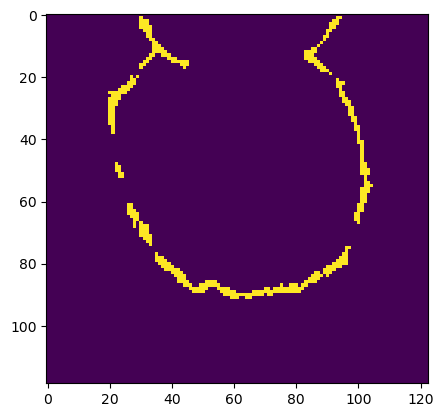

In [8]:
zslice = 80
plt.imshow(segmentation_binary[zslice,:,:])

In [18]:
# a point cloud is simply a mesh with no faces

point_cloud = tcmesh.ObjMesh(vertices=points, faces=[])
point_cloud_pymeshlab = intmsl.convert_to_pymeshlab(point_cloud)

In [20]:
# let's create a pymeshlab instance and add out point cloud to it

# there are three relevant filters we will use:
# generate_simplified_point_cloud - reduce number of points in point cloud
# compute_normal_for_point_clouds - estimate normals for point cloid. This is required for the next step
# generate_surface_reconstruction_screened_poisson - Surface reconstruction by Poisson reconstruction

ms = pymeshlab.MeshSet()
ms.add_mesh(point_cloud_pymeshlab)

ms.generate_simplified_point_cloud(samplenum=1000)
ms.compute_normal_for_point_clouds(k=20, smoothiter=2)
ms.generate_surface_reconstruction_screened_poisson(depth=8, fulldepth=5,)

ms.meshing_isotropic_explicit_remeshing(iterations=10, targetlen=pymeshlab.PercentageValue(1))

mesh_reconstructed = intmsl.convert_from_pymeshlab(ms.current_mesh())

In [21]:
mesh_reconstructed.faces.shape

(22143, 3)

In [22]:
#| export

def reconstruct_poisson(points, samplenum=1000, k_neighbor_normals=10, reconstruc_args=None):
    """
    Reconstruct triangular mesh from point cloud.
    
    Recommended to use isotropic remeshing after to improve mesh quality (remesh_pymeshlab).
    Wrapper of pymeshlab filter generate_surface_reconstruction_screened_poisson
    See for pymeshlab.readthedocs.io/en/latest/filter_list.html for its arguments.
    
    Parameters
    ----------
    points : np.array of shape (n_points, 3)
        Point cloud.
    samplenum : int
        Sample number for point cloud simplification. Smaller values
        lead to more simplification of point cloud and faster processing
    k_neighbor_normals : int
        Nearest neighbors for constructing normal vectors to point cloud
    reglue : bool
        Glue back after cutting
    reconstruc_args : dict or None
        Arguments to surface reconstruction algorithm/

    Returns
    -------
    tcmehs.ObjMesh
        Reconstructed surface.

    """
    if reconstruc_args is None:
        reconstruc_args = dict()
    point_cloud = tcmesh.ObjMesh(vertices=points, faces=[])
    point_cloud_pymeshlab = intmsl.convert_to_pymeshlab(point_cloud)
    ms = pymeshlab.MeshSet()
    ms.add_mesh(point_cloud_pymeshlab)
    ms.generate_simplified_point_cloud(samplenum=samplenum)
    ms.compute_normal_for_point_clouds(k=k_neighbor_normals, smoothiter=2)
    ms.generate_surface_reconstruction_screened_poisson(**reconstruc_args)
    return intmsl.convert_from_pymeshlab(ms.current_mesh())

In [23]:
reconstruct_poisson(points)

## Subdivision / simplification

**Subdivision with `pymeshlab`**
- Works well and preserves UV maps if:
    - Use `meshing_surface_subdivision_midpoint`
    - Cut along seams before subdividing, `mesh.cut_along_seams()`
    - Other methods mess up UV mapping (`meshing_surface_subdivision_loop` the least badly)

In [7]:
#| export

def subdivide_pymeshlab(mesh, threshold=1, iterations=3, reglue=True, decimals=None):
    """
    Refine mesh by edge subdivision using pymeshlab.
    
    Subdivides all edges by placing new vertices at edge midpoints. Preserves UV information,
    by cuts the mesh along seams and (optionally) glueing back after. New texture vertices
    are also placed at texture-edge midpoints. 
    
    In contrast to remeshing_igl.subdivide_igl, you can choose to subdivide long edges only,
    which is very useful to increase mesh resolution only where necessary.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    threshold : float
        All the edges longer than this threshold will be refined. In percent?
        Lower values mean more subdivision.  Setting this value to zero will
        force an uniform refinement.
    iterations : int
        Filter iterations
    reglue : bool
        Glue back after cutting
    decimals : int or None
        Decimal precision for merging vertices when regluing. If None, estimated from average
        edge mesh length as -4*log_10(avg length)

    Returns
    -------
    mesh_subdiv : ObjMesh
        Subdivided mesh.
    
    """
    mesh_cut = mesh.cut_along_seams()
    mesh_pymeshlab = intmsl.convert_to_pymeshlab(mesh_cut)
    ms = pymeshlab.MeshSet()
    ms.add_mesh(mesh_pymeshlab)
    ms.meshing_surface_subdivision_midpoint(threshold=pymeshlab.PercentageValue(threshold))
    mesh_subdiv = intmsl.convert_from_pymeshlab(ms.current_mesh(), reconstruct_texture_from_faces=False)
    if reglue:
        mesh_subdiv = tcmesh.glue_seams(mesh_subdiv, decimals=decimals)

    return mesh_subdiv

In [8]:
mesh_test = tcmesh.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [9]:
mesh_subdiv = subdivide_pymeshlab(mesh_test, reglue=True, threshold=1)

In [7]:
mesh_test.vertices.shape, mesh_subdiv.vertices.shape

((20212, 3), (24768, 3))

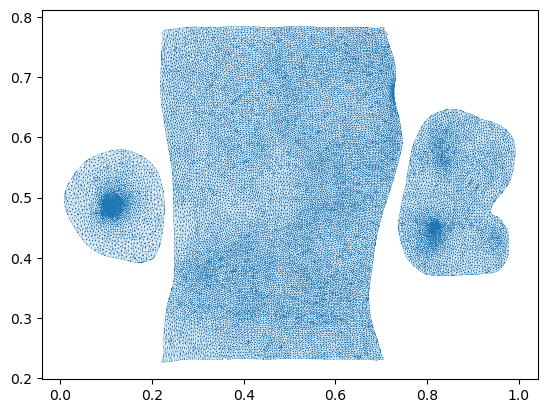

In [10]:
plt.triplot(*mesh_subdiv.texture_vertices.T, mesh_subdiv.texture_tris, lw=0.2)

**Simplification/decimation with `pymeshlab`**

For this, we need to use `meshing_decimation_quadric_edge_collapse_with_texture`, which only works when reading meshes from disk (bug in `pymeshlab`).

Note: this only works when the mesh is areay cut along seams. The meshlab filters for doing that don't work.

This unfortunately also degrades UV information - not really usable.

## Isotropic remeshing

Will degrade UV information. Only use it before you create your UV maps.

In [4]:
#| export

def remesh_pymeshlab(mesh, targetlen=1, iterations=10):
    """
    Remesh mesh using pymeshlab.
    
    This creates a triangulation of triangles which are close to equilateral and
    everywhere the same shape. Very useful to improve the output of
    marching cubes. Uses the meshing_isotropic_explicit_remeshing filter.
    
    This function erases UV information!
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    targetlen : float
        Percent value for target edge length.
    iterations : int
        Number of iterations.

    Returns
    -------
    mesh_remeshed : ObjMesh
        Simplified mesh.
    
    """
    if not mesh.is_triangular:
        warnings.warn(f"Warning: mesh not triangular - result may be incorrect", RuntimeWarning)
    if not mesh.only_vertices:
        warnings.warn(f"Warning: texture information will be discarded", RuntimeWarning)
    
    mesh_pymeshlab = intmsl.convert_to_pymeshlab(mesh, add_texture_info=False)
    ms = pymeshlab.MeshSet()
    ms.add_mesh(mesh_pymeshlab)
    ms.meshing_isotropic_explicit_remeshing(iterations=iterations, targetlen=pymeshlab.PercentageValue(targetlen),
                                            splitflag=True, collapseflag=True, swapflag=True,
                                            smoothflag=True, reprojectflag=True, adaptive=False)
    mesh_pymeshlab_remeshed = ms.current_mesh()
    mesh_remeshed = intmsl.convert_from_pymeshlab(mesh_pymeshlab_remeshed, reconstruct_texture_from_faces=False)    
    return mesh_remeshed

In [5]:
mesh = tcmesh.ObjMesh.read_obj("movie_example/uv_sphere.obj")

In [6]:
mesh_remeshed = remesh_pymeshlab(mesh, iterations=10, targetlen=5)

In [8]:
mesh_remeshed.only_vertices

True

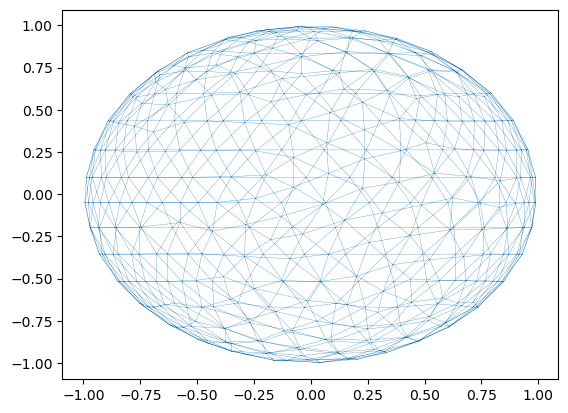

In [9]:
plt.triplot(*mesh_remeshed.vertices[:,:2].T, mesh_remeshed.tris, lw=0.2)

In [129]:
mesh_remeshed.write_obj("movie_example/isotropic_remeshed.obj")